![人工智慧 - 自由團隊](https://raw.githubusercontent.com/chenkenanalytic/img/master/af/aifreeteam.png)


<center>Welcome to the image recognition practice for Traditional Chinese Handwriting Characters by AI . FREE Team.</center>
<br>
<center>歡迎大家來到 AI . FREE Team 所開發的繁體中文手寫圖像辨識實作。 </center>
<br>

<center>(Author: Yen-Lin 博士, Chen Ken；Date of published: 2020/4/29；AI . FREE Team Website: https://aifreeblog.herokuapp.com/)</center>

說明：此圖像辨識實作使用 <a href="https://github.com/AI-FREE-Team/Traditional-Chinese-Handwriting-Dataset">Traditional Chinese Handwriting Dataset</a> 專案之資料集。

# Step 0: 匯入套件

In [1]:
from platform import python_version
import os
import shutil
import numpy as np
import pandas as pd
import PIL.Image
from matplotlib import pyplot as plt 
'''
繁體中文顯示設定
'''
from matplotlib.font_manager import FontProperties
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout  
from tensorflow.keras.optimizers import *

print( 'Python Version: ', python_version() )
print( 'TensorFlow Version: ', tf.__version__ )
print( 'Keras Version: ', tf.keras.__version__ ) 

Python Version:  3.6.9
TensorFlow Version:  2.2.0-rc3
Keras Version:  2.3.0-tf


# Step 1: 使用 Data Deployment 教學，下載繁體中文手寫資料集
資料部署教學：<a href="https://colab.research.google.com/github/AI-FREE-Team/Traditional-Chinese-Handwriting-Dataset/blob/master/Data_Deployment_colab.ipynb#scrollTo=BtJidZSSed2C">範例連結</a>

In [2]:
!git clone https://github.com/AI-FREE-Team/Traditional-Chinese-Handwriting-Dataset.git

fatal: destination path 'Traditional-Chinese-Handwriting-Dataset' already exists and is not an empty directory.


In [0]:
import os
import zipfile
import shutil

OutputFolder = '/content/Handwritten_Data'

In [4]:
if not os.path.exists(OutputFolder):
  os.mkdir(OutputFolder)
  print( f'Create the new "{OutputFolder}" folder' )

os.chdir(OutputFolder)

### 檢查路徑
!pwd

/content/Handwritten_Data


In [5]:
CompressedFiles = []

os.chdir('/content/Traditional-Chinese-Handwriting-Dataset/data')

for item in os.listdir():  
  if item.endswith('.zip'): # Check for ".zip" extension.
    file_path = os.path.abspath(item) # Get full path of the compressed file. 
    CompressedFiles.append(file_path)

for file in CompressedFiles:     
  # Construct a ZipFile object with the filename, and then extract it.
  zip_ref = zipfile.ZipFile(file).extractall(OutputFolder) 
  
  source_path = OutputFolder + '/cleaned_data(50_50)'
  img_list = os.listdir(source_path)

  for img in img_list:
      shutil.move(source_path + '/' + img, OutputFolder) # Move a file to another location. 
  
  shutil.rmtree(OutputFolder + '/cleaned_data(50_50)') 
  print(f'Decompress successfully {file} ......')

print( 'Moving images according to traditional Chinese characters......' )

ImageList = os.listdir(OutputFolder)
ImageList = [img for img in ImageList if len(img)>1]
WordList = list(set([w.split('_')[0] for w in ImageList]))

for w in WordList:
  try:
    os.chdir(OutputFolder) # Change the current working directory to OutputPath.
    os.mkdir(w) # Create the new word folder in OutputPath.
    MoveList = [img for img in ImageList if w in img]
                
  except: 
    os.chdir(OutputFolder)
    MoveList = [ img for img in ImageList if w in img ]
  
  finally:            
    for img in MoveList:
      old_path = OutputFolder + '/' + img
      new_path = OutputFolder + '/' + w + '/' + img
      shutil.move( old_path, new_path )

print( 'Data Deployment completed.' )

Decompress successfully /content/Traditional-Chinese-Handwriting-Dataset/data/cleaned_data(50_50)-20200420T071507Z-002.zip ......
Decompress successfully /content/Traditional-Chinese-Handwriting-Dataset/data/cleaned_data(50_50)-20200420T071507Z-004.zip ......
Decompress successfully /content/Traditional-Chinese-Handwriting-Dataset/data/cleaned_data(50_50)-20200420T071507Z-001.zip ......
Decompress successfully /content/Traditional-Chinese-Handwriting-Dataset/data/cleaned_data(50_50)-20200420T071507Z-003.zip ......
Moving images according to traditional Chinese characters......
Data Deployment completed.


In [6]:
a=0
b=0

for item in os.listdir(OutputFolder):
  a += 1
  for i in os.listdir(OutputFolder + '/' + item):
    b +=1


print('總共: ' + str(a) + ' 個字(資料夾) / 總共: ' + str(b) + '個樣本')
print('平均每個字有: ' + str(b/a) + ' 個樣本')

總共: 4803 個字(資料夾) / 總共: 250712個樣本
平均每個字有: 52.19904226525089 個樣本


# Step 2: 訓練集與自製測試集路徑

In [0]:
os.chdir('/content')
os.mkdir('Traditional_Chinese_Testing_Data')
os.chdir('/content/Traditional_Chinese_Testing_Data')

In [0]:
!git clone https://github.com/AI-FREE-Team/Handwriting-Chinese-Characters-Recognition

### 自製繁中手寫測試集 :   

利用小畫家自製繁體中文字   
* 底圖大小: 50x50 像素   
* 白底黑字    
* 像素筆線條粗細: 1 像素   

將用小畫家自製的繁中手寫文字，以 png 檔儲存，且放於以該字為名的子資料夾中，如下圖所示:   
![自製繁中手寫資料集](https://raw.githubusercontent.com/AI-FREE-Team/Traditional-Chinese-Handwriting-Dataset/master/img/HomeMade_Traditional_Chinese_Dataset.png)

In [32]:
'''
RawDataPath: 繁中手寫資料集路徑
TraningDataPath: 訓練集路徑
TestingDataPath: 自製繁中手寫資料集路徑
'''
RawDataPath = '/content/Handwritten_Data'
TraningDataPath = '/content/Traditional_Chinese_Testing_Data/Handwriting-Chinese-Characters-Recognition/train data'
TestingDataPath = '/content/Traditional_Chinese_Testing_Data/Handwriting-Chinese-Characters-Recognition/test data'

os.chdir( RawDataPath )
print( 'Current working directory:', os.getcwd() ) 

Current working directory: /content/Handwritten_Data


# Step 3: 訓練集   

從繁體中文手寫資料集中，選擇欲辨識的繁體中文字集，作為訓練集。

In [10]:
SelectedWords = [ '人', '工', '智', '慧' ]

os.chdir( RawDataPath )
try: 
    os.mkdir( TraningDataPath ) 

except:
    shutil.rmtree( TraningDataPath )
    os.mkdir( TraningDataPath ) 

finally: 
    nonexistence = []
    for c in SelectedWords:
        try: 
            shutil.copytree( RawDataPath+'/'+c, TraningDataPath+'/'+c )
        except: 
            nonexistence.append( c )
            
    if len(nonexistence)>1: 
        print( f'There are {len(nonexistence)} characters that are not in dataset. \n{nonexistence}' )
    elif len(nonexistence)==1:
        print( f'There is {len(nonexistence)} character that is not in dataset. \n{nonexistence}' )
    else: print('')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20154 missing from current font.
  font.set_text(s, 0.0, flags=flags)
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 20154 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 24037 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 24037 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 26234 missing from current font.
  font.set_text(s, 0.0, flags=fl

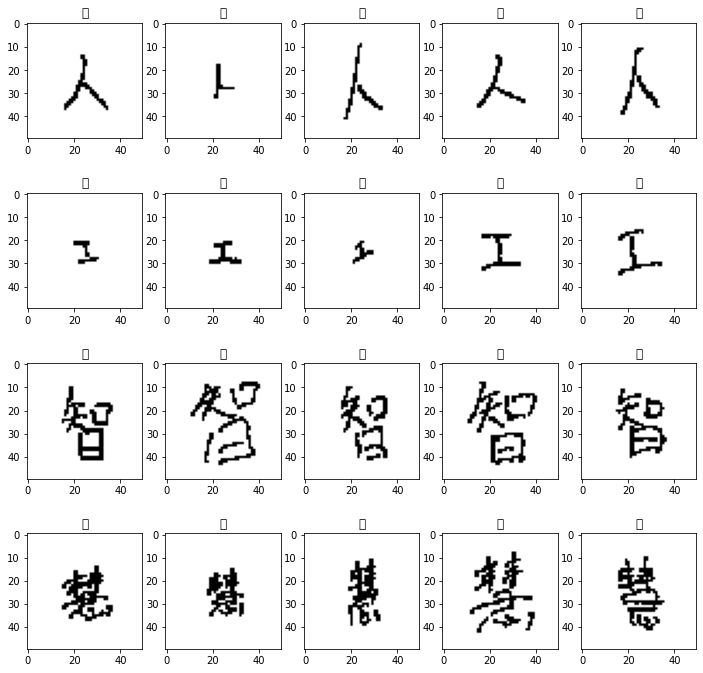

In [11]:
def Loading_Image( image_path ):
    img = load_img( image_path )  
    img = tf.constant( np.array(img) )  
    return img

def Show( image, title=None ) :
    if len( image.shape )>3 :
        image = tf.squeeze( image, axis=0 )   

    plt.imshow( image )
    if title:
        plt.title( title )
        

img_list = []
for c in SelectedWords : 
    folder_path = TraningDataPath+'/'+c
    file_names = os.listdir( folder_path )
    for i in range(5) :
        img_list.append( folder_path+'/'+file_names[i] )

plt.gcf().set_size_inches( (12,12) ) 
for i in range(20):      
    plt.subplot(4,5,i+1)
    title = img_list[i].split('/')[-1].split('_')[-2]
    img = Loading_Image( img_list[i] )
    Show( img, title )

# Step 4: (超)參數

In [0]:
Num_Classes = len(SelectedWords)
Image_Size = ( 50, 50 )
Epochs = 50
Batch_Size = 8

# Step 5: 資料擴增( Data Augmentation ) 

## (5.1) 訓練集

In [0]:
Train_Data_Genetor = ImageDataGenerator( rescale = 1./255, validation_split = 0.2,
                                         width_shift_range = 0.05,   
                                         height_shift_range = 0.05,
                                         zoom_range = 0.1,  
                                         horizontal_flip = False )

In [18]:
Train_Generator = Train_Data_Genetor.flow_from_directory( TraningDataPath ,
                                                          target_size = Image_Size,
                                                          batch_size = Batch_Size,
                                                          class_mode = 'categorical',
                                                          shuffle = True, 
                                                          subset = 'training' )

Found 164 images belonging to 4 classes.


batch 1: 
 shape of images: (8, 50, 50, 3) 
 shape of labels: (8, 4)


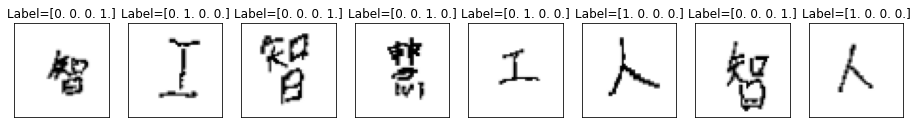

batch 2: 
 shape of images: (8, 50, 50, 3) 
 shape of labels: (8, 4)


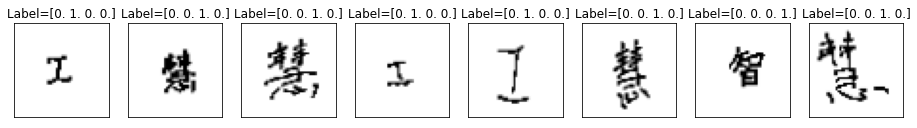

batch 3: 
 shape of images: (8, 50, 50, 3) 
 shape of labels: (8, 4)


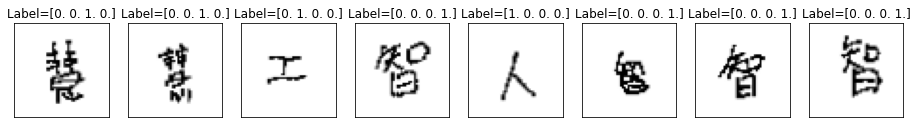

batch 4: 
 shape of images: (8, 50, 50, 3) 
 shape of labels: (8, 4)


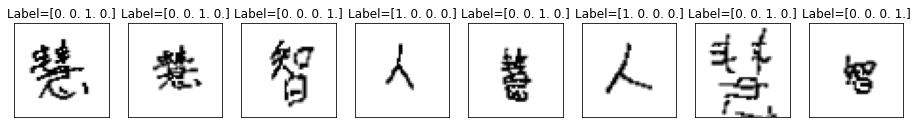

batch 5: 
 shape of images: (8, 50, 50, 3) 
 shape of labels: (8, 4)


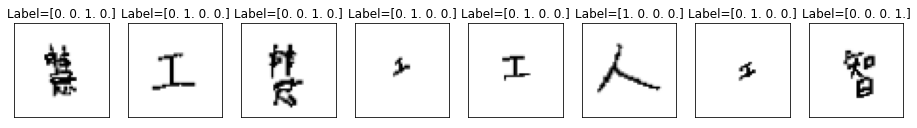

batch 6: 
 shape of images: (8, 50, 50, 3) 
 shape of labels: (8, 4)


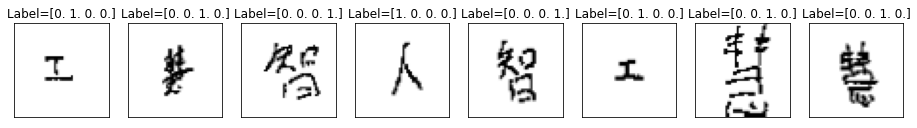

batch 7: 
 shape of images: (8, 50, 50, 3) 
 shape of labels: (8, 4)


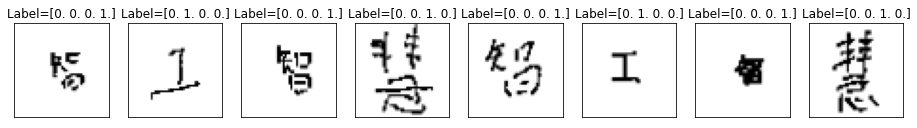

batch 8: 
 shape of images: (8, 50, 50, 3) 
 shape of labels: (8, 4)


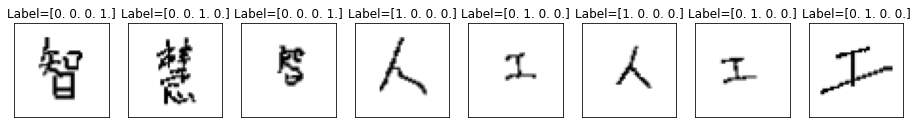

batch 9: 
 shape of images: (8, 50, 50, 3) 
 shape of labels: (8, 4)


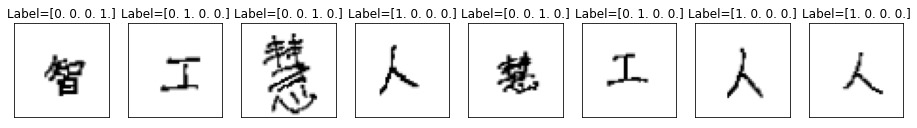

batch 10: 
 shape of images: (8, 50, 50, 3) 
 shape of labels: (8, 4)


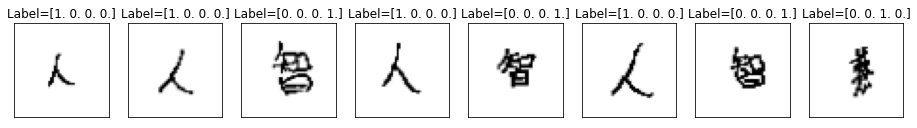

batch 11: 
 shape of images: (8, 50, 50, 3) 
 shape of labels: (8, 4)


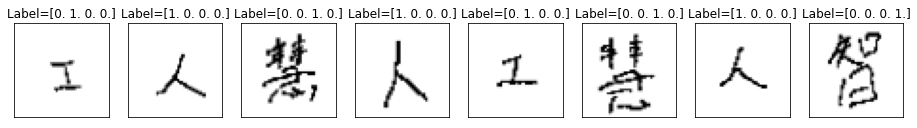

batch 12: 
 shape of images: (8, 50, 50, 3) 
 shape of labels: (8, 4)


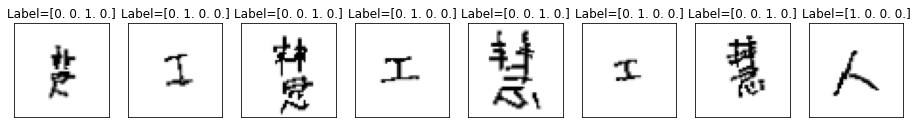

batch 13: 
 shape of images: (8, 50, 50, 3) 
 shape of labels: (8, 4)


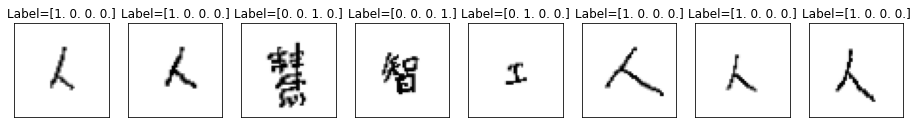

batch 14: 
 shape of images: (8, 50, 50, 3) 
 shape of labels: (8, 4)


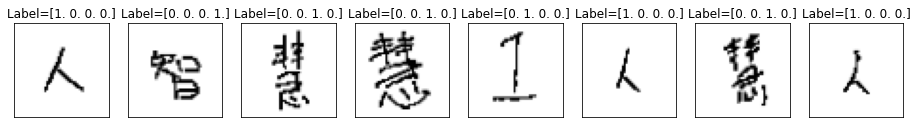

batch 15: 
 shape of images: (8, 50, 50, 3) 
 shape of labels: (8, 4)


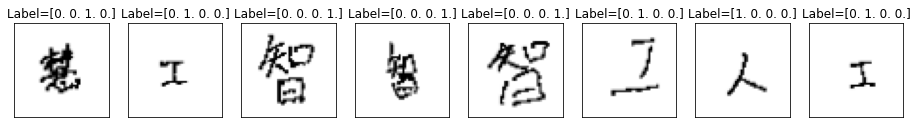

batch 16: 
 shape of images: (8, 50, 50, 3) 
 shape of labels: (8, 4)


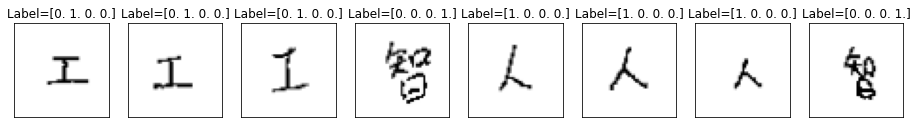

batch 17: 
 shape of images: (8, 50, 50, 3) 
 shape of labels: (8, 4)


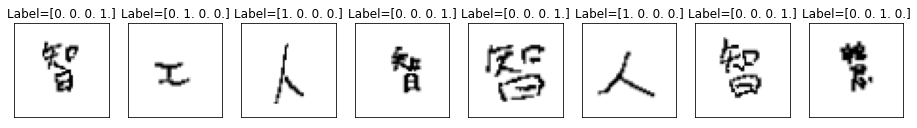

batch 18: 
 shape of images: (8, 50, 50, 3) 
 shape of labels: (8, 4)


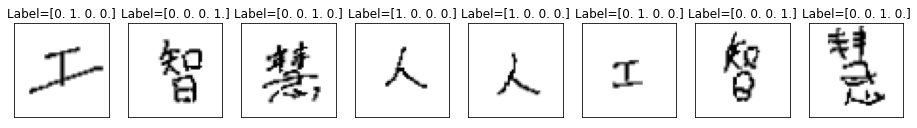

batch 19: 
 shape of images: (8, 50, 50, 3) 
 shape of labels: (8, 4)


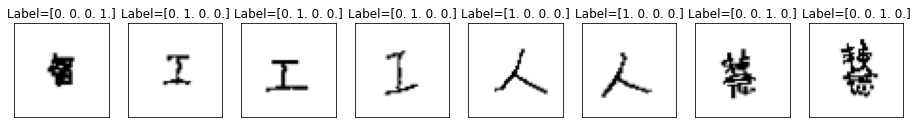

batch 20: 
 shape of images: (8, 50, 50, 3) 
 shape of labels: (8, 4)


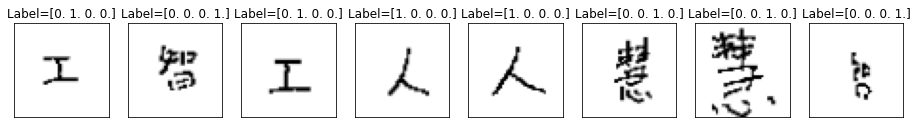

batch 21: 
 shape of images: (4, 50, 50, 3) 
 shape of labels: (4, 4)


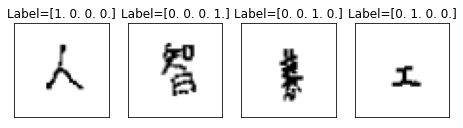

There are 21 batches.


In [19]:
def Plot_Genetor( imgs, labels=[], grid=(1,10), size=(20,2) ):
    n = len( imgs )             
    plt.gcf().set_size_inches(size) 
    for i in range(n):           
        ax = plt.subplot( grid[0], grid[1], i+1 )   
        ax.imshow( imgs[i] )            
        if len(labels):
            ax.set_title( f'Label={labels[i]}' )   
        ax.set_xticks([]); ax.set_yticks([]) 
    plt.show()  

batch = 1
for data, label in Train_Generator:
    print( f'batch {batch}: \n shape of images: {data.shape} \n shape of labels: {label.shape}' )
    Plot_Genetor( data, label )
    batch += 1
    if batch > len(Train_Generator): 
        break

print( f'There are {len(Train_Generator)} batches.' )

## (5.2) 驗證集

In [0]:
Val_Data_Genetor = ImageDataGenerator( rescale=1./255, validation_split = 0.2 )

In [0]:
Val_Generator = Train_Data_Genetor.flow_from_directory( TraningDataPath ,
                                                        target_size = Image_Size,
                                                        batch_size = Batch_Size,
                                                        class_mode = 'categorical',
                                                        shuffle = True, 
                                                        subset = 'validation' )

# Step 6: 建立及編譯模型

In [0]:
CNN = Sequential( name = 'CNN_Model' )
CNN.add( Conv2D( 5, kernel_size = (2,2), padding = 'same', 
                 input_shape = (Image_Size[0],Image_Size[1],3), name = 'Convolution' ) )
CNN.add( MaxPooling2D( pool_size = (2,2), name = 'Pooling' ) )
CNN.add( Flatten( name = 'Flatten' ) )
CNN.add( Dropout( 0.5, name = 'Dropout_1' ) )
CNN.add( Dense( 512, activation = 'relu', name = 'Dense' ) )
CNN.add( Dropout( 0.5, name = 'Dropout_2' ) )
CNN.add( Dense( Num_Classes, activation = 'softmax', name = 'Softmax' ) )
CNN.summary()

In [0]:
CNN.compile( optimizer = Adam(),
             loss = 'categorical_crossentropy', 
             metrics = ['accuracy'] )

# Step 7: 訓練及儲存模型

In [0]:
History = CNN.fit( Train_Generator,
                   steps_per_epoch = Train_Generator.samples//Batch_Size,
                   validation_data = Val_Generator,
                   validation_steps = Val_Generator.samples//Batch_Size,
                   epochs = Epochs )

In [0]:
Train_Accuracy = History.history['accuracy']
Val_Accuracy = History.history['val_accuracy']
Train_Loss = History.history['loss']
Val_Loss = History.history['val_loss']
epochs_range = range(Epochs)

plt.figure( figsize=(14,4) )
plt.subplot( 1,2,1 )
plt.plot( range( len(Train_Accuracy) ), Train_Accuracy, label='Train' ) 
plt.plot( range( len(Val_Accuracy) ), Val_Accuracy, label='Validation' ) 
plt.legend( loc='lower right' )
plt.title( 'Accuracy' )

plt.subplot( 1,2,2 )
plt.plot( range( len(Train_Loss) ), Train_Loss, label='Train' )
plt.plot( range( len(Val_Loss) ), Val_Loss, label='Validation' )
plt.legend( loc='upper right' )
plt.title( 'Loss')

plt.show()

### 儲存模型

In [0]:
os.chdir( '/content' )
CNN.save( 'CNN_Model.h5' )

# Step 8: 自製繁中手寫測試集預測

## (8.1) 建立自製測試集的生成器( Generator )及走訪器( Iterator )

In [61]:
Test_Data_Genetor = ImageDataGenerator( rescale=1./255 )
Test_Generator = Test_Data_Genetor.flow_from_directory( TestingDataPath,
                                                        target_size = Image_Size,
                                                        shuffle = False,
                                                        class_mode = 'categorical' )

Found 8 images belonging to 4 classes.


batch 1: 
 shape of images: (8, 50, 50, 3) 
 shape of labels: (8, 4)


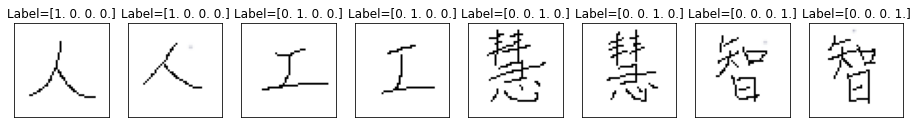

In [62]:
batch = 1
for data, label in Test_Generator:
    print( f'batch {batch}: \n shape of images: {data.shape} \n shape of labels: {label.shape}' )
    Plot_Genetor( data, label )
    batch += 1
    if batch > 1: 
        break

## (8.2) 載入模型且預測

In [63]:
Test_Generator.reset()

Predicts=CNN.predict(Test_Generator,verbose=1, steps =8)

8/8 [==============================] - 0s 4ms/step


## (8.3) 檢視預測結果

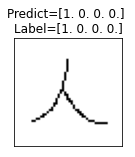

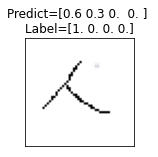

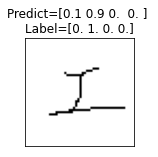

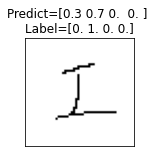

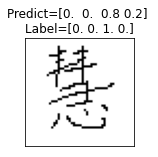

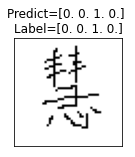

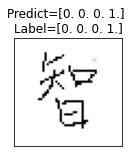

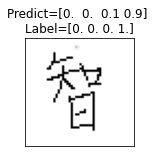

In [64]:
test_data, test_label = Test_Generator.next()

def Plot_Predict( img, labels=[], predicts=[], size=(20,2) ):             
    plt.gcf().set_size_inches(size)           
    ax = plt.subplot( )   
    ax.imshow( img )            
    ax.set_title( f'Predict={predicts.round(1)} \nLabel={labels}' )   
    ax.set_xticks([]); ax.set_yticks([]) 
    plt.show() 
    
for data, label, predict_label in zip(test_data,  test_label, Predicts):
    Plot_Predict( data, label, predict_label )

## (8.4) 其他做法

 - 無分類資料夾預測方法

In [0]:
os.mkdir('test')

for i in os.listdir(TestingDataPath):
  folder = TestingDataPath + '/' + i
  for f in os.listdir(folder):
    img_file = folder + '/' + f
    shutil.copyfile(img_file,'/content/test/' + f)

In [0]:
from tensorflow.python.keras.preprocessing import image

directory = os.fsencode('/content/test')

# load trained model
model = load_model('CNN_Model.h5')

# predict all photos (loop though the folder)
for f in os.listdir(directory):
    f = os.fsdecode(f)
    img = image.load_img('/content/test/'+ str(f), target_size=(50, 50))

    x = image.img_to_array(img)
    x = np.expand_dims(x, axis = 0)
    pred = model.predict(x)

    ax = plt.subplot( )
    ax.imshow(img) 
    ax.set_title( f'Predict={pred.round(1)}' )
    ax.set_xticks([]); ax.set_yticks([]) 
    plt.gcf().set_size_inches((20,2))
    plt.show()
    print(f)